<a href="https://www.kaggle.com/concyclics/dog-vs-cat-classification-vgg-model?scriptVersionId=89118185" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Dog vs Cat Classification
#### Author: Concyclics
### ***Upvote*** me please if you thought it's helpful

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import zipfile
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pylab

## 1. Load datas

In [2]:
split=0.2
seed=19260817
batch_size=100
img_size=(224,224)

train_ds = keras.utils.image_dataset_from_directory(
    '../input/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='training',
)
val_ds = keras.utils.image_dataset_from_directory(
    '../input/dog-vs-cat-classification/train/train',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=split,
    subset='validation',
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2022-03-02 13:57:04.579881: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 13:57:04.706401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 13:57:04.707459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 13:57:04.712782: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


### 1.1 visualize some images

2022-03-02 13:57:12.944790: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


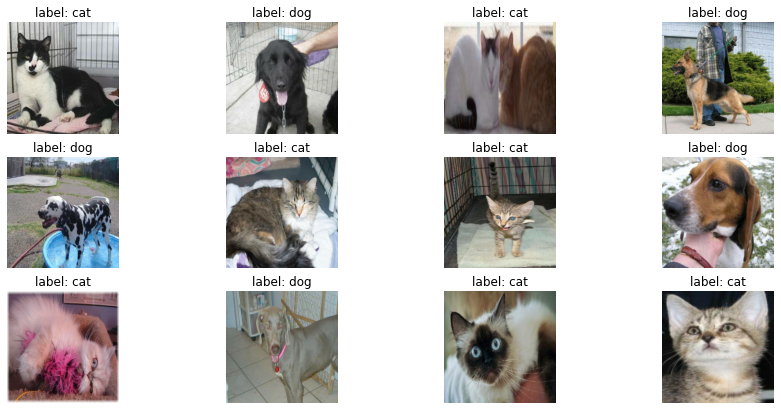

In [3]:
label_names={0:'cat',1:'dog'}

fig, ax = plt.subplots(figsize=(15, 7))
for img, label in train_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4,i+1)
        plt.imshow(img.numpy()[i]/255)
        plt.axis("off")
        plt.title("label: "+label_names[label.numpy()[i]])
        #rint("label:", label.numpy()[i])
plt.show()

## 2. VGG model

### 2.1 history plot display

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_history(history,title=''):  
    if title!='':
        title+=' '
    #Ploting the Loss and Accuracy Curves
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,6))
    #Loss
    sns.lineplot(data = history.history['loss'], label = 'Training Loss', ax = ax[0])
    sns.lineplot(data = history.history['val_loss'], label = 'Validation Loss', ax = ax[0])
    ax[0].legend(loc = 'upper right')
    ax[0].set_title(title+'Loss')
    #Accuracy
    sns.lineplot(data = history.history['accuracy'], label = 'Training Accuracy', ax = ax[1])
    sns.lineplot(data = history.history['val_accuracy'], label = 'Validation Accuracy', ax = ax[1])
    ax[1].legend(loc = 'lower right')
    ax[1].set_title(title+'Accuracy')

### 2.2 augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        #layers.RandomFlip("horizontal"),
        #layers.RandomRotation(0.2),
        #layers.RandomTranslation(0.14,0.14),
        #layers.RandomZoom(0.2),
        #layers.RandomContrast(0.2),
    ]
)

### 2.3 callback

In [6]:
CB = [
            keras.callbacks.ModelCheckpoint(
            filepath="fine_tuning.keras",
            save_best_only=True,
            monitor="val_loss"),
    
            keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0005,
            patience=3)
]

### 2.4 vgg16 model

In [7]:
vgg16_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    #weights=None,
    include_top=False)

#vgg16_base.trainable = True
vgg16_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg16_base.trainable_weights))

vgg16_base.summary()

58900480/58889256 [==============================] - 1s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   

In [8]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg16_base(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg16_model = keras.Model(inputs, outputs)
vgg16_model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      multiple                  0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               642278

In [9]:
history_vgg16 = vgg16_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=CB
    )
vgg16_model = keras.models.load_model("fine_tuning.keras")


Epoch 1/100


2022-03-02 13:57:25.198716: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


200/200 [==============================] - 118s 512ms/step - loss: 23.4861 - accuracy: 0.9558 - val_loss: 12.0413 - val_accuracy: 0.9818
Epoch 2/100
200/200 [==============================] - 68s 332ms/step - loss: 11.8380 - accuracy: 0.9810 - val_loss: 7.6574 - val_accuracy: 0.9860
Epoch 3/100
200/200 [==============================] - 70s 342ms/step - loss: 4.8620 - accuracy: 0.9877 - val_loss: 8.1567 - val_accuracy: 0.9856
Epoch 4/100
200/200 [==============================] - 68s 332ms/step - loss: 2.8234 - accuracy: 0.9913 - val_loss: 5.4949 - val_accuracy: 0.9866
Epoch 5/100
200/200 [==============================] - 68s 331ms/step - loss: 1.3809 - accuracy: 0.9939 - val_loss: 5.9676 - val_accuracy: 0.9848
Epoch 6/100
200/200 [==============================] - 61s 297ms/step - loss: 0.9276 - accuracy: 0.9953 - val_loss: 5.7357 - val_accuracy: 0.9850
Epoch 7/100
200/200 [==============================] - 58s 283ms/step - loss: 0.5898 - accuracy: 0.9963 - val_loss: 4.5126 - val_acc

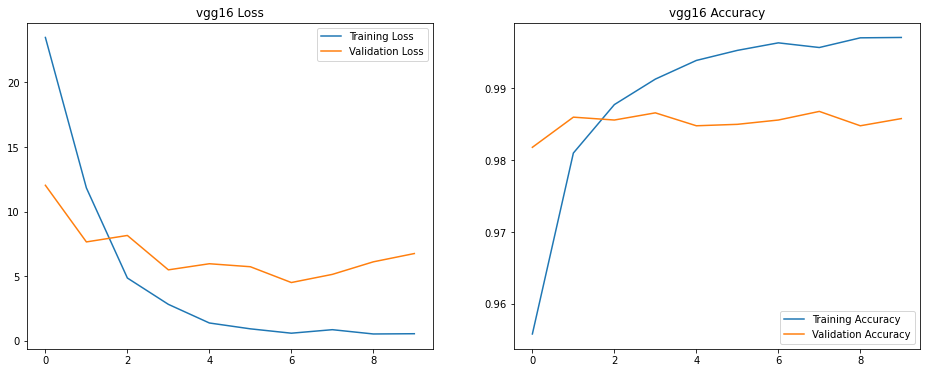

In [10]:
plot_history(history_vgg16,'vgg16')

### 2.5 vgg19 model

In [11]:
vgg19_base  = keras.applications.vgg19.VGG19(
    weights="imagenet",
    include_top=False)

#vgg19_base.trainable = True
vgg19_base.trainable = False

print("This is the number of trainable weights "
      "before freezing the conv base:", len(vgg19_base.trainable_weights))

vgg19_base.summary()

80150528/80134624 [==============================] - 2s 0us/step
This is the number of trainable weights before freezing the conv base: 0
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   

In [12]:
inputs = keras.Input(shape=img_size+(3,))
x = data_augmentation(inputs)
x = keras.applications.vgg19.preprocess_input(x)
x = vgg19_base(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)
vgg19_model = keras.Model(inputs, outputs)
vgg19_model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
vgg16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      multiple                  0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               642278

In [13]:
history_vgg19 = vgg19_model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=CB
    )
vgg19_model = keras.models.load_model("fine_tuning.keras")

Epoch 1/100
200/200 [==============================] - 78s 379ms/step - loss: 37.1825 - accuracy: 0.9405 - val_loss: 9.4793 - val_accuracy: 0.9806
Epoch 2/100
200/200 [==============================] - 78s 383ms/step - loss: 13.2392 - accuracy: 0.9764 - val_loss: 7.0828 - val_accuracy: 0.9854
Epoch 3/100
200/200 [==============================] - 76s 374ms/step - loss: 8.3463 - accuracy: 0.9812 - val_loss: 4.4815 - val_accuracy: 0.9864
Epoch 4/100
200/200 [==============================] - 79s 383ms/step - loss: 4.4796 - accuracy: 0.9860 - val_loss: 9.7976 - val_accuracy: 0.9704
Epoch 5/100
200/200 [==============================] - 78s 380ms/step - loss: 2.6946 - accuracy: 0.9894 - val_loss: 4.5098 - val_accuracy: 0.9842
Epoch 6/100
200/200 [==============================] - 77s 372ms/step - loss: 2.1902 - accuracy: 0.9908 - val_loss: 5.8033 - val_accuracy: 0.9844


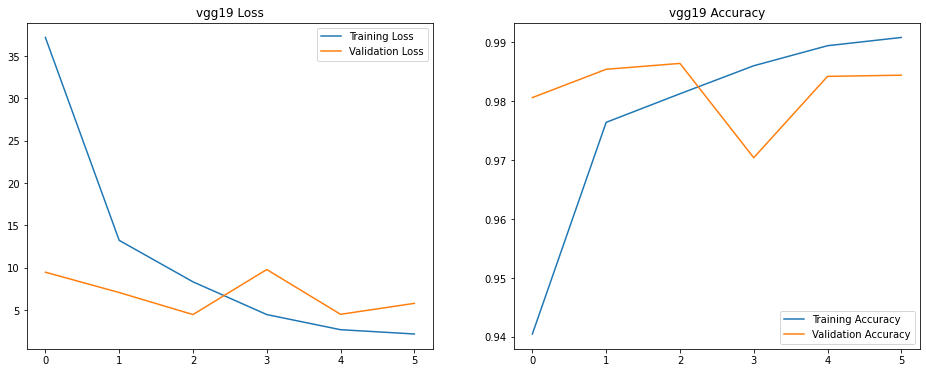

In [14]:
plot_history(history_vgg19,'vgg19')

### 2.6 Compare two models

In [15]:
vgg16_test=vgg16_model.evaluate(val_ds)
vgg19_test=vgg19_model.evaluate(val_ds)

50/50 [==============================] - 18s 322ms/step - loss: 4.4815 - accuracy: 0.9864


In [16]:
pd.set_option('precision',10)
compare_table=pd.DataFrame([vgg16_test,vgg19_test],columns=['loss','accuracy'],index=['vgg16','vgg19'])
cm = sns.light_palette("green", as_cmap=True)
compare_table.head().style.background_gradient(cmap=cm)

,loss,accuracy
vgg16,4.5125837326,0.9855999947
vgg19,4.4814600945,0.9864000082


In [17]:
if vgg16_test[1]>vgg19_test[1]:
    model=vgg16_model
else:
    model=vgg19_model

## 3. Prediction

### 3.1 prepare testing data

In [18]:
import os
test_filenames = os.listdir("../input/dog-vs-cat-classification/test/test")
test_df = pd.DataFrame({
    'id': test_filenames
})
nb_samples = test_df.shape[0]
nb_samples

8000

In [19]:
from keras.preprocessing.image import ImageDataGenerator, load_img
test_gen = ImageDataGenerator()
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../input/dog-vs-cat-classification/test/test", 
    x_col='id',
    y_col=None,
    class_mode=None,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

Found 8000 validated image filenames.


### 3.2 predict and view

In [20]:
predict = model.predict(test_generator)
test_df['labels'] = np.argmax(predict, axis=-1)

In [21]:
test_df

,id,labels
0,005463.jpg,1
1,000304.jpg,1
2,001940.jpg,1
3,007289.jpg,1
4,005491.jpg,0
...,...,...
7995,004881.jpg,0
7996,003638.jpg,0
7997,007845.jpg,0
7998,007882.jpg,1


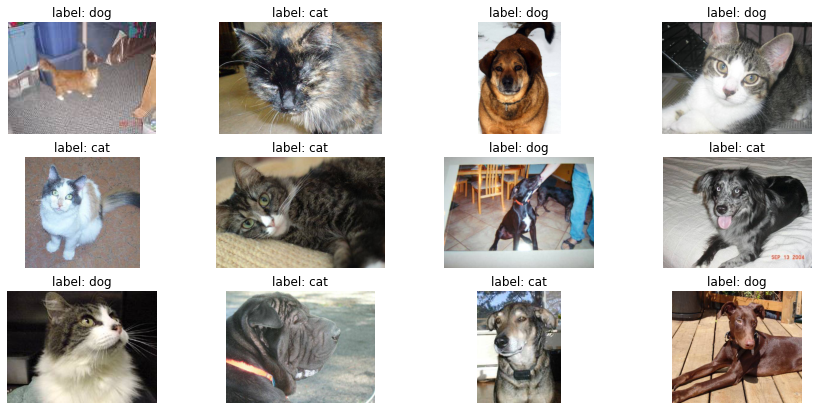

In [22]:
label_names={0:'cat',1:'dog'}
fig, ax = plt.subplots(figsize=(15, 7))
i=0
for index, row in test_df.sample(12).iterrows():
    i+=1
    plt.subplot(3, 4,i)
    img=plt.imread('../input/dog-vs-cat-classification/test/test/'+row['id'])
    plt.imshow(img)
    plt.axis("off")
    plt.title("label: "+label_names[label.numpy()[i]])
    #rint("label:", label.numpy()[i])
plt.show()

### 3.3 submit

In [23]:
test_df.set_index('id')
test_df.to_csv('submission.csv',index=False)